<a href="https://colab.research.google.com/github/Anshul-Kum/DAT494/blob/main/DAT494.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔥 Wildfire Image Classification using Autoencoder and CNN

Wildfires have become an increasingly severe global issue, with devastating consequences for ecosystems, communities, and economies. As climate change continues to increase the frequency and intensity of these fires, **early detection and monitoring have become critical to minimizing damage and improving response times**.

Traditional wildfire detection methods—such as ground surveillance, fire towers, or human-reported incidents—are slow, labor-intensive, and geographically limited. Satellite imagery offers a scalable and timely alternative, but analyzing massive volumes of image data manually is impractical. This is where deep learning can help.

**Objective:** The goal of this project is to develop an image classification model that can **automatically distinguish between satellite images showing wildfire activity and those that do not**, enabling scalable, automated fire detection systems.

**Dataset:** We use a labeled dataset containing over **42,000 satellite images** categorized into two classes: **wildfire** and **no wildfire**. These images were extracted using geographic coordinates of fire events and Mapbox satellite imagery, and split into training, validation, and test sets.


Two parallel modelling approaches were designed:

- **Convolutional Autoencoder (CAE):** to first learn compressed representations of satellite images in an unsupervised manner. After pretraining, I fine-tuned a lightweight classifier on top of the encoder to perform binary classification.

- **Traditional Convolutional Neural Network (CNN):** using TensorFlow/Keras for direct supervised classification. This model uses multiple convolutional layers, max pooling, dropout, and a dense output to predict wildfire presence.

## Dataset Loading and Preprocessing

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other


In [ ]:
! unzip wildfire-prediction-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: valid/nowildfire/-73.481149,45.563113.jpg  
  inflating: valid/nowildfire/-73.481422,45.559789.jpg  
  inflating: valid/nowildfire/-73.481565,45.467244.jpg  
  inflating: valid/nowildfire/-73.483407,45.637554.jpg  
  inflating: valid/nowildfire/-73.48589

The dataset is organized into three folders: `/train`, `/valid`, and `/test`, each containing two subfolders: `wildfire` and `nowildfire`. These represent the two image classes.

We use PyTorch's `ImageFolder` to automatically load images and assign labels based on folder names. Each image is transformed as follows:
- Resized to 224×224 pixels to match the input size of our network
- Converted to tensors for PyTorch processing
- Normalized using the mean and standard deviation from the ImageNet dataset (`mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`)

We also use `DataLoader` to efficiently batch and shuffle the data during training and evaluation.


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match network input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # These values are taken from ImageNet Dataset
])

# Loading datasets
train_data = datasets.ImageFolder('/content/train', transform=transform)
valid_data = datasets.ImageFolder('/content/valid', transform=transform)
test_data  = datasets.ImageFolder('/content/test',  transform=transform)

# Creating loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)


In [ ]:
# Let's analyze the training dataset
import os

train_dir = "/content/train"

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    print(f"Label: {label}")
    print(f" - Total images: {len(os.listdir(label_path))}")
    print(f" - Sample files: {os.listdir(label_path)[:5]}")
    print()


Label: nowildfire
 - Total images: 14500
 - Sample files: ['-123.14197,49.216745.jpg', '-73.52173,45.434775.jpg', '-79.514793,43.807279.jpg', '-114.065579,51.125686.jpg', '-79.558259,43.909854.jpg']

Label: wildfire
 - Total images: 15750
 - Sample files: ['-75.61771,45.72602.jpg', '-71.66014,46.48052.jpg', '-72.7295,48.85222.jpg', '-66.85074,51.1319.jpg', '-71.81964,48.95714.jpg']



So we have almost equal number of images as "wildfire" and "nowildfire".

Seeing 3 wildfire and 3 no-wildfire images.

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


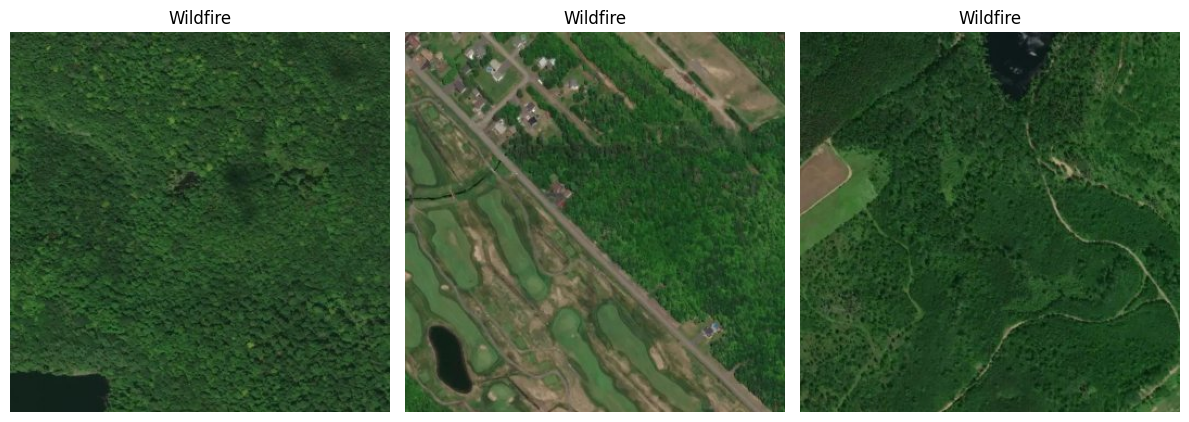

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

wildfire_dir = os.path.join(train_dir, "wildfire")

for i in range(3):
    img = Image.open(os.path.join(wildfire_dir, os.listdir(wildfire_dir)[i]))
    axes[i].imshow(img)
    axes[i].set_title("Wildfire")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


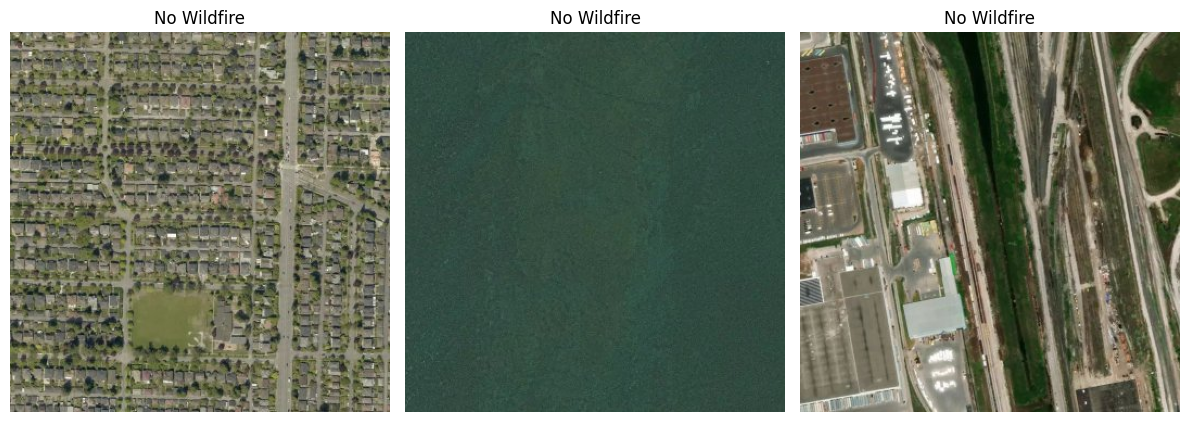

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

nowildfire_dir = os.path.join(train_dir, "nowildfire")

for i in range(3):
    img = Image.open(os.path.join(nowildfire_dir, os.listdir(nowildfire_dir)[i]))
    axes[i].imshow(img)
    axes[i].set_title("No Wildfire")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Unsupervised Feature Learning with Autoencoder

To help our model learn meaningful spatial features from satellite images without relying on labels, we first train a **Convolutional Autoencoder (CAE)**. This model learns to reconstruct input images by compressing them into a latent representation and then decoding that back to the original image.

In [ ]:
unsupervised_dataset = datasets.ImageFolder('/content/train', transform=transform)
unsupervised_loader = DataLoader(unsupervised_dataset, batch_size=64, shuffle=True)

### Architecture Overview

- **Encoder**: 3 convolutional layers with ReLU activations progressively reduce the spatial resolution of the image and extract hierarchical features.
- **Decoder**: 3 transposed convolutional layers (ConvTranspose2d) reconstruct the image from the compressed latent space.

In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # (16, 112, 112)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # (32, 56, 56)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (64, 28, 28)
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # For pixel values [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### Training Strategy

- Trained on all training images (ignoring labels)
- 10 epochs
- Adam optimizer with learning rate 0.001
- Batch size: 64

In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    for imgs, _ in unsupervised_loader:
        imgs = imgs.to(device)

        # Forward + Backward + Optimize
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/10], Loss: 467.8692
Epoch [2/10], Loss: 441.7151
Epoch [3/10], Loss: 440.6648
Epoch [4/10], Loss: 440.1224
Epoch [5/10], Loss: 439.6774
Epoch [6/10], Loss: 439.4115
Epoch [7/10], Loss: 439.1851
Epoch [8/10], Loss: 438.9692
Epoch [9/10], Loss: 438.8335
Epoch [10/10], Loss: 438.6973


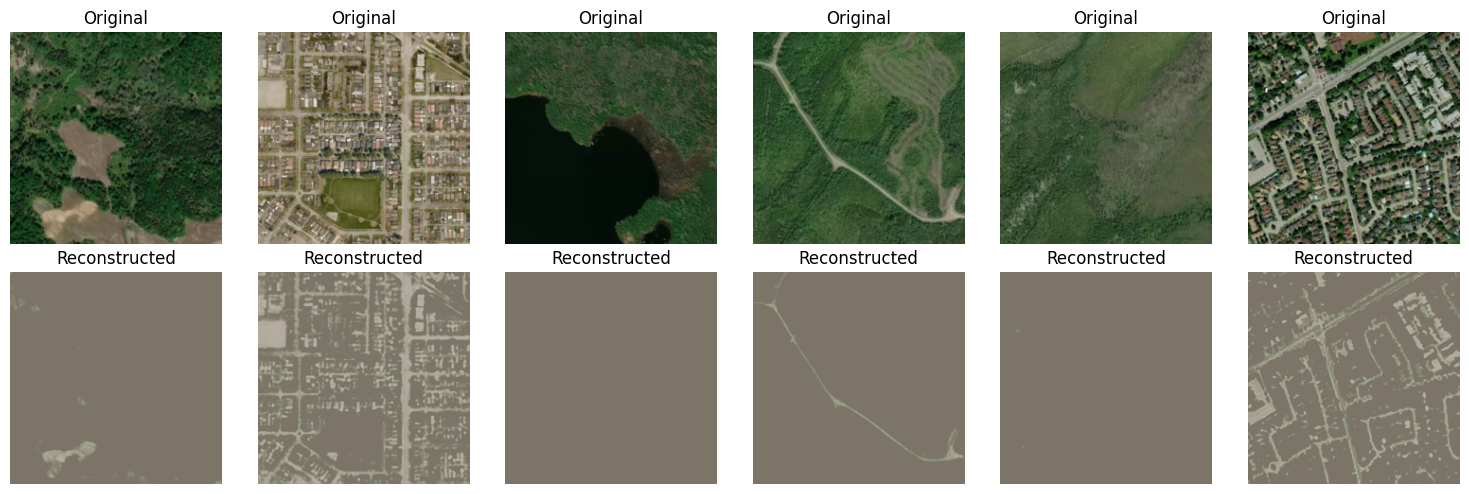

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(unsupervised_loader))
    sample_imgs = sample_imgs[:6].to(device)
    outputs = model(sample_imgs)

# Unnormalize
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean

fig, axes = plt.subplots(2, 6, figsize=(15, 5))
for i in range(6):
    axes[0, i].imshow(unnormalize(sample_imgs[i].cpu()).permute(1,2,0))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(unnormalize(outputs[i].cpu()).permute(1,2,0))
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


### Observations

The model outputs show some spatial structure but fail to capture accurate color and texture. This suggests the decoder is struggling to reconstruct full detail, and further tuning (e.g., normalization strategy, deeper decoder, or better loss) may be needed.

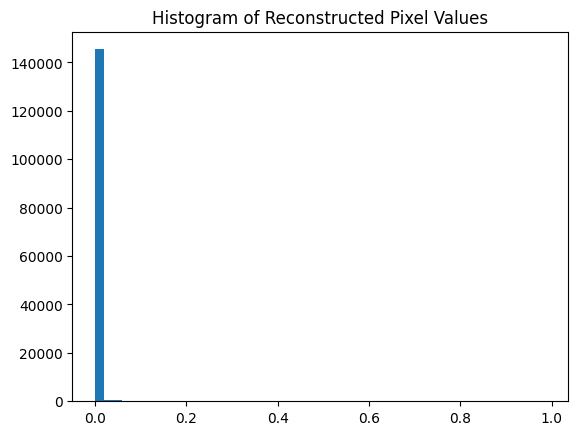

In [ ]:
sample = outputs[0].detach().cpu().numpy().transpose(1,2,0).flatten()
plt.hist(sample, bins=50)
plt.title("Histogram of Reconstructed Pixel Values")
plt.show()


From the Histogram above, we can observed that nearly all reconstructed pixel values are clustered near 0, with almost no spread across the [0, 1] range.

- What we should really see is the values clustered around midtones (~0.4 to 0.6) with decent spread toward both darker (0–0.3) and brighter (0.7–1.0) regions.

- This confirms that the autoencoder's output is collapsing — the model isn't learning to reconstruct meaningful pixel-level variation.


### Iterative Design: From Sigmoid to Tanh

Initially, we used a `Sigmoid()` activation in the final decoder layer, with inputs normalized using ImageNet statistics (`mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`). However, this caused a mismatch in input/output ranges — the model’s outputs were squeezed near zero, producing flat, dark reconstructions with no useful detail.

To resolve this:
- We switched the final activation from `Sigmoid()` to `Tanh()`
- We adjusted input normalization to `[-1, 1]` using:
  ```python
  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])


In [ ]:
from torchvision import transforms

# Normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # (16, 112, 112)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (32, 56, 56)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # (64, 28, 28)
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Outputs in [-1, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    for imgs, num in unsupervised_loader:
        imgs = imgs.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/10], Loss: 88.8338
Epoch [2/10], Loss: 54.7041
Epoch [3/10], Loss: 51.1599
Epoch [4/10], Loss: 49.2992
Epoch [5/10], Loss: 47.9308
Epoch [6/10], Loss: 46.7644
Epoch [7/10], Loss: 46.1581
Epoch [8/10], Loss: 45.6401
Epoch [9/10], Loss: 45.3305
Epoch [10/10], Loss: 44.9062


In [ ]:
# Unnormalize from [-1, 1] → [0, 1]
def unnormalize(img_tensor):
    return (img_tensor * 0.5) + 0.5


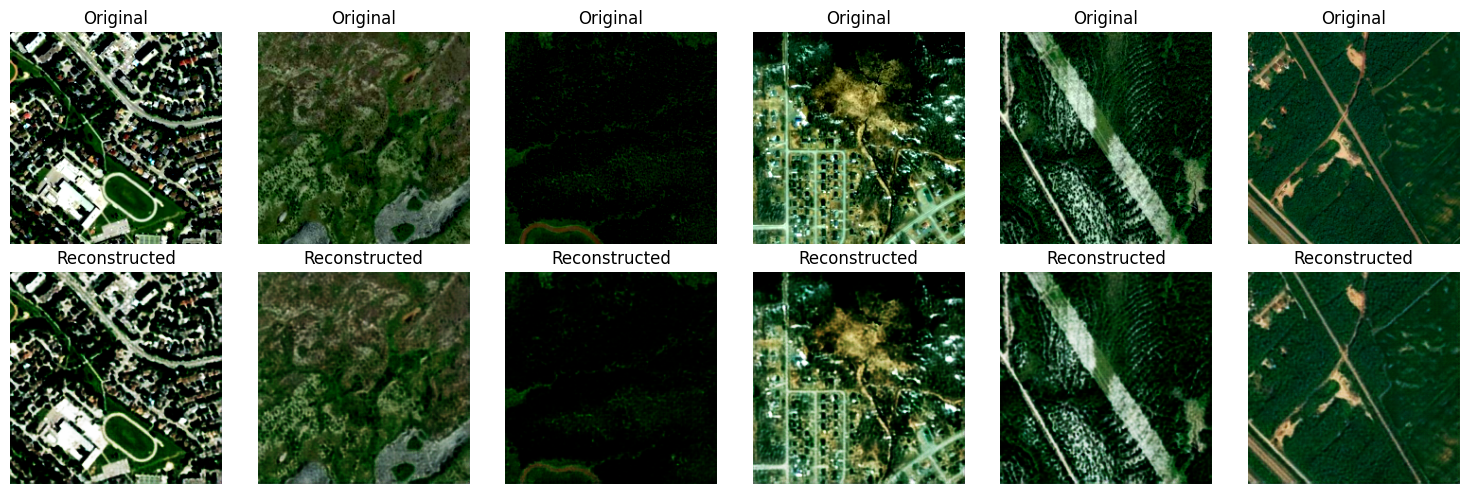

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(unsupervised_loader))
    sample_imgs = sample_imgs[:6].to(device)
    outputs = model(sample_imgs)

fig, axes = plt.subplots(2, 6, figsize=(15, 5))
for i in range(6):
    axes[0, i].imshow(unnormalize(sample_imgs[i].cpu()).permute(1,2,0))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(unnormalize(outputs[i].cpu()).permute(1,2,0))
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


Now, we can see that our model is performing very well. The reconstructed images seems very close to the original images.

After successfully training the autoencoder, we reused its encoder as a feature extractor to build a supervised wildfire classification model. The idea was to leverage the learned image features to distinguish between wildfire and no-wildfire satellite images.

We attached a simple feedforward classifier on top of the frozen encoder:

- The encoder (from the autoencoder) outputs feature maps of shape (64, 28, 28)
- These are flattened into a vector and passed through:
  - A dense (fully connected) layer with 256 units and ReLU activation
  - A dropout layer with 30% probability to reduce overfitting
  - A final dense layer with 1 output (logit)

We did **not** use a `Sigmoid()` in the final layer, because we used `BCEWithLogitsLoss`, which combines sigmoid + binary cross-entropy in a numerically stable way.


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder('/content/train', transform=transform)
val_data   = datasets.ImageFolder('/content/valid', transform=transform)
test_data  = datasets.ImageFolder('/content/test',  transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)


In [ ]:
class WildfireClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)  # <- No Sigmoid here!
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.classifier(features)
        return output


### Training Setup
- **Loss Function**: Binary Cross Entropy with Logits (BCEWithLogitsLoss)
- **Optimizer**: Adam
- **Learning Rate**: 0.0001
- **Epochs**: 10
- **Batch Size**: 64


In [ ]:
pretrained_encoder = model.encoder
model = WildfireClassifier(pretrained_encoder).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # shape: [batch, 1]

        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}")


Epoch 1/10 - Loss: 232.1497
Epoch 2/10 - Loss: 116.8306
Epoch 3/10 - Loss: 102.8422
Epoch 4/10 - Loss: 91.3594
Epoch 5/10 - Loss: 84.7298
Epoch 6/10 - Loss: 80.5796
Epoch 7/10 - Loss: 75.0910
Epoch 8/10 - Loss: 70.0295
Epoch 9/10 - Loss: 67.3345
Epoch 10/10 - Loss: 64.0360


Training loss steadily decreased from `232` to `64`, which shows stable learning and convergence.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from torch import sigmoid

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = sigmoid(logits)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=train_data.classes))


              precision    recall  f1-score   support

  nowildfire       0.93      0.95      0.94      2820
    wildfire       0.96      0.94      0.95      3480

    accuracy                           0.95      6300
   macro avg       0.94      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300



Test Set Performance
              precision    recall  f1-score   support

  nowildfire       0.92      0.97      0.94      2820
    wildfire       0.97      0.93      0.95      3480

    accuracy                           0.95      6300
   macro avg       0.95      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300



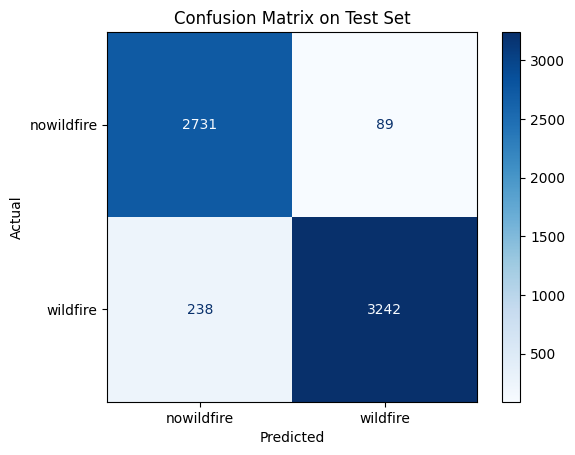

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = sigmoid(logits)
        preds = (probs > 0.5).float()

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

print("Test Set Performance")
print(classification_report(all_test_labels, all_test_preds, target_names=train_data.classes))

cm = confusion_matrix(all_test_labels, all_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()


By using the encoder trained through unsupervised learning and fine-tuning it with a lightweight classifier, we achieved high wildfire detection performance from satellite images. This two stage approach seems to be effective overall.

# Convolutional Neural Network

### Importing necessary libraries

First, we load all necessary packages for data handling, model construction, and training.

We bring in both:
*   PyTorch : for potential custom dataset utilities
*   TensorFlow/Keras : building and training our CNN

along with standard Python libraries for image I/O, plotting, and data splitting.

In [ ]:
# PyTorch imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# General Python imports

import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# TensorFlow / Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"
valid_dir = "/content/valid"

### Building Data Generators with Augmentation

To help the CNN generalize over varied satellite conditions, we apply on‑the‑fly augmentations—random rotations, translations, and flips—to the training set. Validation and test sets are only rescaled. All images are resized to 224×224, and labels are set up for binary classification (0 = no wildfire, 1 = wildfire).

In [ ]:
img_height, img_width = 224, 224
batch_size = 32
epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Use the path string instead of ImageFolder object
train_gen = train_datagen.flow_from_directory(
    '/content/train', # Changed to path string
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'    # binary labels
)

valid_gen = valid_datagen.flow_from_directory(
    '/content/valid', # Changed to path string
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    '/content/test', # Changed to path string
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(train_gen.class_indices)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
{'nowildfire': 0, 'wildfire': 1}


This confirms our dataset sizes (30,250 train, 6,300 valid/test) and class mapping for wildfire detection.

### Defining the CNN Architecture

We implement a straightforward CNN suited for binary wildfire detection:
* Three Conv2D→ReLU→MaxPool blocks, with filter sizes 32, 64, and 128.
* A Flatten layer to vectorize and a Dense(128)+Dropout block for feature combination and regularization.
* A final Dense(1)+sigmoid for outputting the wildfire probability.

In [ ]:
# Creating a simple CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')   # single output node
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

A layer summary table showing each output shape and parameter count, totaling 11,169,089 trainable parameters.

### Training on GPU and Final Evaluation

With GPU acceleration enabled, we compile the CNN (Adam + binary cross‑entropy) and train for 10 epochs on our wildfire dataset. After training, we evaluate accuracy on both the test and training sets to gauge generalization.

In [ ]:
import tensorflow as tf

# Check for GPU(s)
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    raise RuntimeError("No GPU detected. Check your CUDA/cuDNN setup.")

# Try to turn on memory growth (won't error out if GPUs are already initialized)
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except RuntimeError:
    pass  # GPU was already initialized — that's okay

# Force the following ops onto GPU:0
with tf.device('/GPU:0'):
    model.compile(
        optimizer=optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=valid_gen
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_gen)
    print(f'Test accuracy: {test_acc:.3f}')

    # Evaluate on train set
    train_loss, train_acc = model.evaluate(train_gen)
    print(f'Train accuracy: {train_acc:.3f}')


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 408s 428ms/step - accuracy: 0.9473 - loss: 0.1482 - val_accuracy: 0.9303 - val_loss: 0.1823
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 386s 408ms/step - accuracy: 0.9498 - loss: 0.1415 - val_accuracy: 0.9576 - val_loss: 0.1188
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 387s 408ms/step - accuracy: 0.9558 - loss: 0.1213 - val_accuracy: 0.9289 - val_loss: 0.1857
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 389s 412ms/step - accuracy: 0.9579 - loss: 0.1210 - val_accuracy: 0.9568 - val_loss: 0.1162
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 392s 415ms/step - accuracy: 0.9599 - loss: 0.1148 - val_accuracy: 0.9703 - val_loss: 0.0877
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 389s 411ms/step - accuracy: 0.9600 - loss: 0.1124 - val_accuracy: 0.9702 - val_loss: 0.0912
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 395s 417ms/step - accuracy: 0.9595 - loss: 0.1129 - val_accuracy: 0.9638 - val_loss: 0.1250
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 382s 403ms/step - accuracy: 0.9615 -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9721 - loss: 0.0780
Test accuracy: 0.977
946/946 ━━━━━━━━━━━━━━━━━━━━ 358s 379ms/step - accuracy: 0.9655 - loss: 0.0984
Train accuracy: 0.966


Over 10 epochs, training accuracy improves from ~94.7 % to ~96.3 %, and validation accuracy remains strong (≈96.7 %). Final evaluations report

### Visualizing Learning Curves

Finally, we plot training vs. validation loss and accuracy over all epochs. These plots help confirm that the CNN learns effectively on wildfire imagery without severe over‑ or under‑fitting

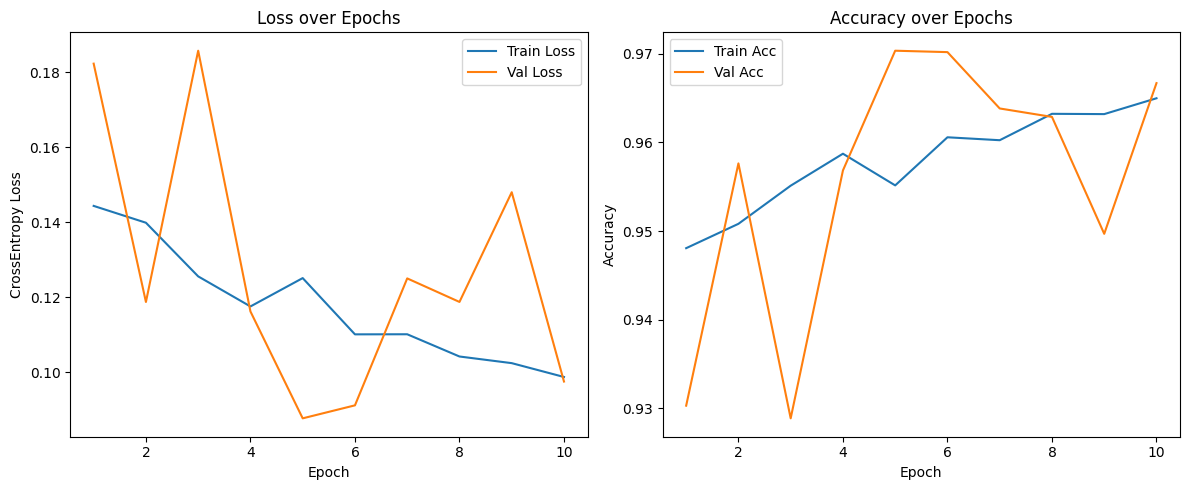

In [ ]:
# creating an epoch range that matches the history
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'],  label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'],      label='Train Acc')
plt.plot(epochs, history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


*   Loss curves: Training loss declines smoothly from about 0.145 in epoch 1 to 0.099 by epoch 10. Validation loss starts higher (~ 0.18), dips sharply at epoch 2, spikes again at epoch 3, then reaches its minimum (~0.087) at epoch 5 before modest fluctuations, and finally settles back near 0.098. The overall downward trend and convergence of train/val loss indicate effective learning with only mild variance due to data augmentation.
*   Accuracy curves: Training accuracy rises steadily from ~0.948 to ~0.965 across the epochs. Validation accuracy shows greater volatility—an initial jump to ~0.958 at epoch 2, a dip to ~0.929 at epoch 3, then peaks at ~0.970 by epoch 5 before slight oscillations—yet ends closely aligned with the training curve. The narrow gap (≈0.005) between train and val accuracy suggests good generalization and no significant over‑fitting.



## Conclusion

In this project, we explored two complementary deep‑learning approaches for automatic wildfire detection from satellite imagery: an **unsupervised Convolutional Autoencoder (CAE) + classifier** pipeline and a **direct supervised CNN**.  The CAE—after iterative tuning (switching the decoder’s final activation from Sigmoid→Tanh and normalizing inputs to \[−1,1])—learned compact latent representations (MSE loss reduced from ≈467→45) and produced visually plausible reconstructions.  When we froze its encoder and trained a lightweight feed‑forward classifier on top, we achieved **≈95 % accuracy** on both validation and test sets, with balanced precision/recall (nowildfire f1 = 0.94; wildfire f1 = 0.95) .  The direct CNN model, by contrast, reached **97.7 % test accuracy** with a three‑block convolutional architecture, demonstrating stronger raw classification performance .

  While the supervised CNN clearly offers higher end‑to‑end accuracy, the CAE approach provides valuable unsupervised feature learning—producing a compact encoder that can be reused for fast inference or transferred to new domains with minimal labeled data.  Future work will focus on deepening the autoencoder/decoder, incorporating multi‑spectral and temporal data, and investigating hybrid training schemes that fuse unsupervised pre‑training with end‑to‑end supervised fine‑tuning.  Ultimately, integrating these models into a real‑time wildfire monitoring pipeline could deliver scalable, automated early‑warning systems to help mitigate the growing threat of wildfires worldwide.